<img src="https://upload.wikimedia.org/wikipedia/commons/e/e4/Cidade_de_luz_e_cor.jpg" alt="Alt text that describes the graphic" title="Title text" />

<h1><center>Airbnb Rio de Janeiro - Data Analysis</center></h1>
<h4><center>January 2021</center></h4>

## Introduction

Rio de Janeiro has always been known by its beautiful beaches and incredible views, such as the Sugar Loaf (Pão de Açúcar) and Christ the Redeemer (Cristo Redentor). During festive periods, like the New Year and Carnival, more than 2 million tourists from all over the world visit the city. Currently, with the creation of Airbnb, a community online service for people to advertise, discover and book accommodations, it's never been easier to find a place to stay and relax.

The dataset that we'll be analyzing in this notebook, provided by [Inside Airbnb] (http://insideairbnb.com/), has a variety of information on all the accommodation listings currently available on Airbnb for the city of Rio de Janeiro .

In this notebook we will analyze how prices vary between regions and between types of accommodation and what factors can influence prices and total of rentals.

***

## First steps

- What information do we have? Which ones don't we have? Which are relevant and which are not?
- We will remove unnecessary information and fill, convert and format those that need adjustment, creating new information based on existing data when necessary.
- We will graphically analyze patterns, trends and correlations to better understand the behavior of the data. 
- Finally, we will try to draw conclusions about the accommodations available on Rio's Airbnb and their hosts. 

***

## Reading the data and checking missing values

In [88]:
# Importing main libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap

plt.style.use('bmh')
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

In [89]:
# Reading the dataset
rj_listings = pd.read_csv('listings.csv')

# Describing basic info about the dataset
print(f'Total number of listings: {rj_listings.shape[0]}')
print(f'Total number of features: {rj_listings.shape[1]}')
print(f'Total number of hosts: {rj_listings["host_id"].nunique()}')
print(f'Total number of neighbourhoods listed: {rj_listings["neighbourhood_cleansed"].nunique()}')

Total number of listings: 25784
Total number of features: 74
Total number of hosts: 16946
Total number of neighbourhoods listed: 151


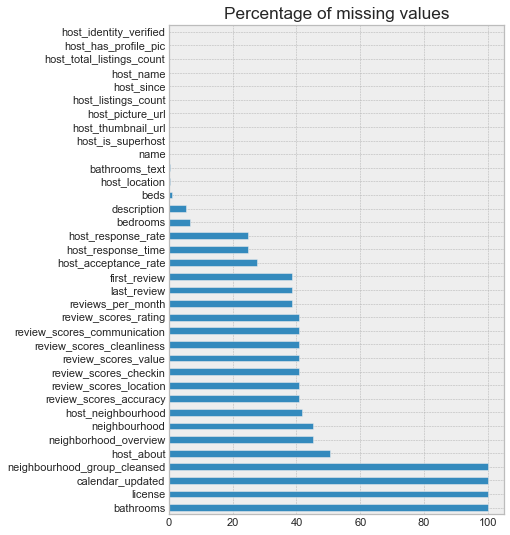

In [90]:
# Creating a dataframe showing all features with missing values
missing_values = rj_listings.isna().mean()*100

missing_values = missing_values[missing_values != 0]

plt.figure(figsize=(6,9))
missing_values.sort_values(ascending=False).plot(kind='barh')
plt.title('Percentage of missing values');

- Since there are no values in this dataset for `bathrooms`, `license`, `calendar_updated` and `neighbourhood_group_cleansed`, we can simply drop these columns.

- More than 50% of the data is missing for the `host_about` column. Also there are other columns with much less data than expected, so we will be dealing with each one of those in specific ways.

***

## Data cleaning

In the next step we will be:
- Removing irrelevant data.
- Filling null values with most common values or averages (not the most accurate way of doing it, but will do for this analysis).
- Converting data types to the correct format.
- Creating new features when necessary.
- Treating outliers.

In [91]:
# Removing unimportant columns, personal data and missing data.
# Some textual data (such as the neighborhood overviews and information 
# about the host) have also been removed, but can be used for further analysis
# in case of an NLP project.

rj_listings.drop(['listing_url','scrape_id','last_scraped','name','description','neighborhood_overview',
                  'picture_url','host_url','host_name','host_since','host_location','host_about',
                  'host_acceptance_rate','host_thumbnail_url','host_picture_url','host_neighbourhood',
                  'host_listings_count','host_total_listings_count','host_has_profile_pic','neighbourhood',
                  'neighbourhood_group_cleansed','bathrooms','bathrooms_text','maximum_nights',
                  'minimum_minimum_nights','maximum_minimum_nights','minimum_maximum_nights','maximum_maximum_nights',
                  'minimum_nights_avg_ntm','maximum_nights_avg_ntm','calendar_updated','has_availability',
                  'availability_60','availability_90','availability_365','calendar_last_scraped',
                  'number_of_reviews_ltm','number_of_reviews_l30d','first_review','last_review',
                  'license','calculated_host_listings_count_entire_homes',
                  'calculated_host_listings_count_private_rooms','calculated_host_listings_count_shared_rooms',
                  'reviews_per_month'], axis=1, inplace=True)

In [92]:
# Filling null values from 'host_response_time' with the most common value ("withing an hour")
rj_listings['host_response_time'] = rj_listings['host_response_time'].fillna(
                                    value=rj_listings['host_response_time'].value_counts().idxmax())

# Converting values in 'host_response_rate' to floats (removing % sign and dividing by 100)
rj_listings['host_response_rate'] = rj_listings['host_response_rate'][
                                    rj_listings['host_response_rate'].notna()].str.strip('%').astype(int)/100

# Filling null values with 'host_responde_rate' mean
rj_listings['host_response_rate'].fillna(rj_listings['host_response_rate'].mean(), inplace=True)

# Dropping null values
rj_listings.dropna(subset=['host_is_superhost','host_identity_verified','beds'], inplace=True)

# Filling null values for 'bedrooms' with 1
rj_listings['bedrooms'].fillna(1, inplace=True)

# Replacing 't' (True) and 'f' (False) to 1 and 0, respectively
rj_listings['host_is_superhost'] = rj_listings['host_is_superhost'].map({'f': 0, 't': 1}).astype(int)
rj_listings['host_identity_verified'] = rj_listings['host_identity_verified'].map({'f': 0, 't': 1}).astype(int)
rj_listings['instant_bookable'] = rj_listings['instant_bookable'].map({'f': 0, 't': 1}).astype(int)

# Removing the $ symbol from the price column and converting it to float
rj_listings['price'] = rj_listings['price'].str.replace(r'[$,]', '').astype(float)

# Converting floats to integers
rj_listings['beds'] = rj_listings['beds'].astype(int)
rj_listings['bedrooms'] = rj_listings['bedrooms'].astype(int)

# Counting how many verification methods each host has
rj_listings['total_host_verifications'] = rj_listings['host_verifications'].str.strip('[]').str.split(',', expand=True).apply(
    lambda x: x.count(), axis=1)

# Counting how many amenities each accommodation has
rj_listings['total_amenities'] = rj_listings['amenities'].str.strip('[]').str.split(',', expand=True).apply(
    lambda x: x.count(), axis=1)

# Dropping 'host_verifications' and 'amenities', since we won't be using them this time (these could be analyzed further
# in order to understand which verification methods and which amenities translates to higher ratings and prices)
rj_listings.drop(labels=['host_verifications','amenities'], axis=1, inplace=True)

## Outliers

There are two columns in this dataset that have outliers: `price` and `minimum_nights`.

- Even though there are some accommodations with prices above $2000, they represent 6 percent of our dataset, and can cause some issues in future analysis. Apparently, some hosts increase their prices to very high numbers in order to "deactivate" these accommodations for any kind of reason, so many times these prices don't represent the truth. To prevent problems with this, we'll drop listings with prices higher than 2000.

- There are also accommodations with very high number of minimum nights. We'll determine that 30 nights is the maximum number possible for the minimum rented nights.

We could increase these limits if we wanted and still have a good amount of data left, but we can work with what we have already.

In [93]:
# Percentages of outliers in relation to the total of listings
pct_price_outliers = round(len(rj_listings[rj_listings['price'] > 2000])/len(rj_listings)*100, 2)

pct_minnght_outliers = round(len(rj_listings[rj_listings['minimum_nights'] > 30])/len(rj_listings)*100, 2)

print(f'{pct_price_outliers}% of the listings have a price per night above $2000.')
print(f'{pct_minnght_outliers}% of the listings have a number of minimum nights above 30.')

6.03% of the listings have a price per night above $2000.
0.78% of the listings have a number of minimum nights above 30.


In [94]:
# As seen below, 75% of our data has a price of $776 and lower and a minimum number of nights of 4 or lower 
rj_listings[['price','minimum_nights']].describe()

price  minimum_nights
count   25538.000000    25538.000000
mean      883.678089        4.782285
std      5203.655554       19.127185
min        32.000000        1.000000
25%       200.000000        1.000000
50%       384.000000        3.000000
75%       776.000000        4.000000
max    593266.000000     1000.000000

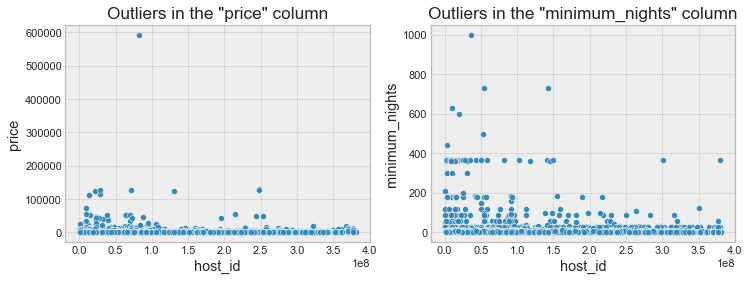

In [95]:
# Plotting these outliers
fig, axes = plt.subplots(1, 2, figsize=(12,4))

sns.scatterplot(data=rj_listings, y='price', x='host_id', ax=axes[0])
axes[0].set_title('Outliers in the "price" column')

sns.scatterplot(data=rj_listings, y='minimum_nights', x='host_id', ax=axes[1])
axes[1].set_title('Outliers in the "minimum_nights" column')

plt.show()

In [96]:
# Dropping outliers from 'price' and 'minimum_nights'
rj_listings.drop(rj_listings[(rj_listings.price > 2000)].index, inplace=True)

rj_listings.drop(rj_listings[(rj_listings.minimum_nights > 30)].index, inplace=True)

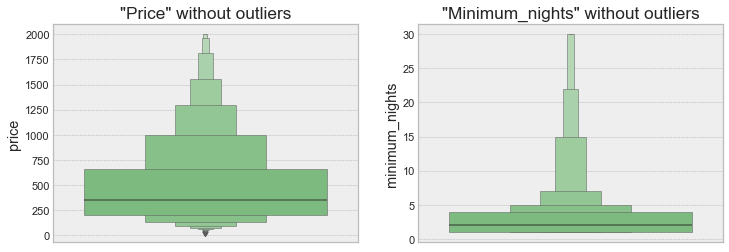

In [97]:
# Plotting "price" and "minimum_nights" columns with outliers removed
fig, axes = plt.subplots(1, 2, figsize=(12,4))

sns.boxenplot(data=rj_listings, y='price', ax=axes[0], palette='Greens')
axes[0].set_title('"Price" without outliers')

sns.boxenplot(data=rj_listings, y='minimum_nights', ax=axes[1], palette='Greens')
axes[1].set_title('"Minimum_nights" without outliers')

plt.show()

## Dealing with missing values from 'review_scores' columns

In [98]:
# Checking how many null values per each 'review_scores' column
cols_reviews = ['review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness','review_scores_checkin',
                'review_scores_communication', 'review_scores_location', 'review_scores_value']
for col in cols_reviews:
    print(f'Percentage of missing values in {col}: {round(rj_listings[col].isna().mean()*100, 2)}%')

Percentage of missing values in review_scores_rating: 38.25%
Percentage of missing values in review_scores_accuracy: 38.3%
Percentage of missing values in review_scores_cleanliness: 38.29%
Percentage of missing values in review_scores_checkin: 38.3%
Percentage of missing values in review_scores_communication: 38.28%
Percentage of missing values in review_scores_location: 38.3%
Percentage of missing values in review_scores_value: 38.29%


In [99]:
# Most of these listings with null values of review_scores don't have any reviews
print('Total of reviews // Quantity:')
print(rj_listings[['review_scores_rating','number_of_reviews']].query('review_scores_rating == "NaN"')
      ['number_of_reviews'].value_counts())

print('\n')

print('Total of reviews // Quantity:')
print(rj_listings[['review_scores_accuracy','number_of_reviews']].query('review_scores_accuracy == "NaN"')
      ['number_of_reviews'].value_counts())

Total of reviews // Quantity:
0    8593
1     461
2      47
3       5
4       4
Name: number_of_reviews, dtype: int64


Total of reviews // Quantity:
0      8593
1       468
2        47
3         5
4         4
159       1
140       1
84        1
115       1
10        1
Name: number_of_reviews, dtype: int64


Unfortunately, we can't just simply drop 40% of the listings that have no review scores and analyze only the ones that have, because then we would be losing a lot of good data about other features. 

In this case, the best solution that I found was to drop these features and create a different dataset with all the listing with non-null values for the review scores. This way we don't lose data for our analysis but can still do some work with these scores later if we want.

In [100]:
# Creating new dataframe with non-nulled review scores
rj_reviews = rj_listings.dropna(subset=cols_reviews)

In [101]:
# Dropping review_scores columns in our main dataset
rj_listings.drop(cols_reviews, axis=1, inplace=True)

***

## Exploratory Data Analysis

With a clean dataset, we can start to understand it more visually. We'll analyze different features such as number of accommodations, room type and price distribution by neighborhood, as well as information about amenities for each accommodation, verifications for each host and how all this affects the chances of a place being rented or not.

In [102]:
# Creating a map showing the distribution of available accommodations for the city of Rio de Janeiro
dist_map_rj = folium.Map(location = [-22.908333, -43.456388], zoom_start=11)

HeatMap(rj_listings[['latitude','longitude']], radius=8,
        gradient={0.2:'blue',0.4:'purple',0.6:'orange',1.0:'red'}).add_to(dist_map_rj)

display(dist_map_rj)

With this interactive heatmap we can take a look at the **neighborhoods with the highest number of accommodations for rent**.

There's definetely a **high concentration** of places near the most famous beaches of Rio, such as **Copacabana, Ipanema, Barra da Tijuca and Leblon**.

But we also see a lot of listings near **urban and central regions** such as **Jacarepaguá, Santa Teresa, Centro and Tijuca**.

- Is there a correlation between price and proximity to the beach? 
- Which neighborhoods are more expensive? 
- Where are people checking in the most?

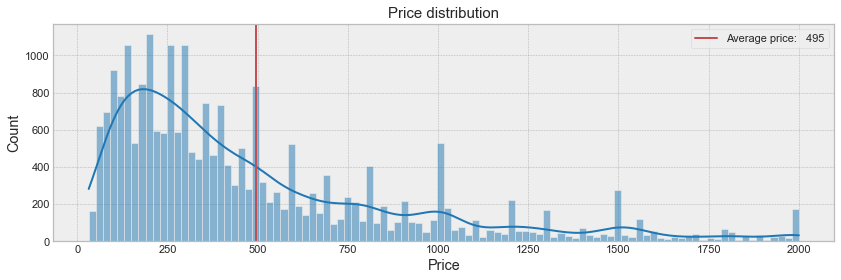

In [103]:
# Plotting price distribution for the entire dataset

plt.figure(figsize=(14,4))

sns.histplot(data=rj_listings, x='price', color='tab:blue', kde=True, bins=100)

plt.axvline(rj_listings['price'].mean(), color='r', label='Average price: {:5.0f}'.format(np.mean(rj_listings['price'])))
plt.xlabel('Price')
plt.title('Price distribution', fontsize=15)
plt.legend()
plt.show()

According to plot above, the price distribution for the entire dataset has a **higher concentration at around \\$230**, and an **average of $495**.

In [104]:
# Creating a dataframe with the total of listings, total of reviews, average price and reviews by listings ratio
# (for each neighborhood)
total_listings = rj_listings['neighbourhood_cleansed'].value_counts()

total_number_reviews = rj_listings.groupby('neighbourhood_cleansed')['number_of_reviews'].sum()

avg_price_neighb = rj_listings.groupby('neighbourhood_cleansed')['price'].mean().sort_values(ascending=False)

neighb_data = pd.concat([total_listings, total_number_reviews, avg_price_neighb], axis=1).sort_values(by='neighbourhood_cleansed', 
                                                                                                      ascending=False)

neighb_data = neighb_data.reset_index().rename(columns={'neighbourhood_cleansed': 'Total of listings',
                                                        'price': 'Average price',
                                                        'number_of_reviews': 'Total number of reviews',
                                                        'index': 'Neighborhood'})

neighb_data['Reviews by listings ratio']=neighb_data['Total number of reviews']/neighb_data['Total of listings']

neighb_data.head()

Neighborhood  Total of listings  Total number of reviews  Average price  \
0       Copacabana               6906                   119532     501.891710   
1  Barra da Tijuca               2278                    25063     613.736611   
2          Ipanema               2197                    48021     686.128812   
3      Jacarepaguá               1253                     7340     516.951317   
4         Botafogo               1158                    13190     379.822971   

   Reviews by listings ratio  
0                  17.308427  
1                  11.002195  
2                  21.857533  
3                   5.857941  
4                  11.390328

In [105]:
# Creating a map showing the average price distribution by neighborhood
geo_rj = 'https://gist.githubusercontent.com/esperanc/db213370dd176f8524ae6ba32433f90a/raw/6dff5654e9ff6395f09f18ea2692f40ed2060cb9/Limite_Bairro.geojson'

price_map_rj = folium.Map(location = [-22.908333, -43.456388], zoom_start=11)

folium.Choropleth(
    geo_data=geo_rj,
    name='choropleth',
    data=neighb_data[neighb_data['Total of listings']>10],
    columns=['Neighborhood', 'Average price'],
    key_on='feature.properties.NOME',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.1,
    nan_fill_opacity=0,
    legend_name='Price distribution'
).add_to(price_map_rj)

display(price_map_rj)

As expected, the **average price** for renting an accommodation is **higher in the most touristic and coastal areas**, such as **Ipanema, Leblon and Joá**, with averages ranging from **\\$650 to \\$720**, even though **Copacabana**, one of the most visited places by tourists, has an **average price of \\$500**.

That doesn't necessarily mean that urban districts are much cheaper. **Jacarepaguá, for instance, averages around \\$515, and Maracanã around \\$525**.

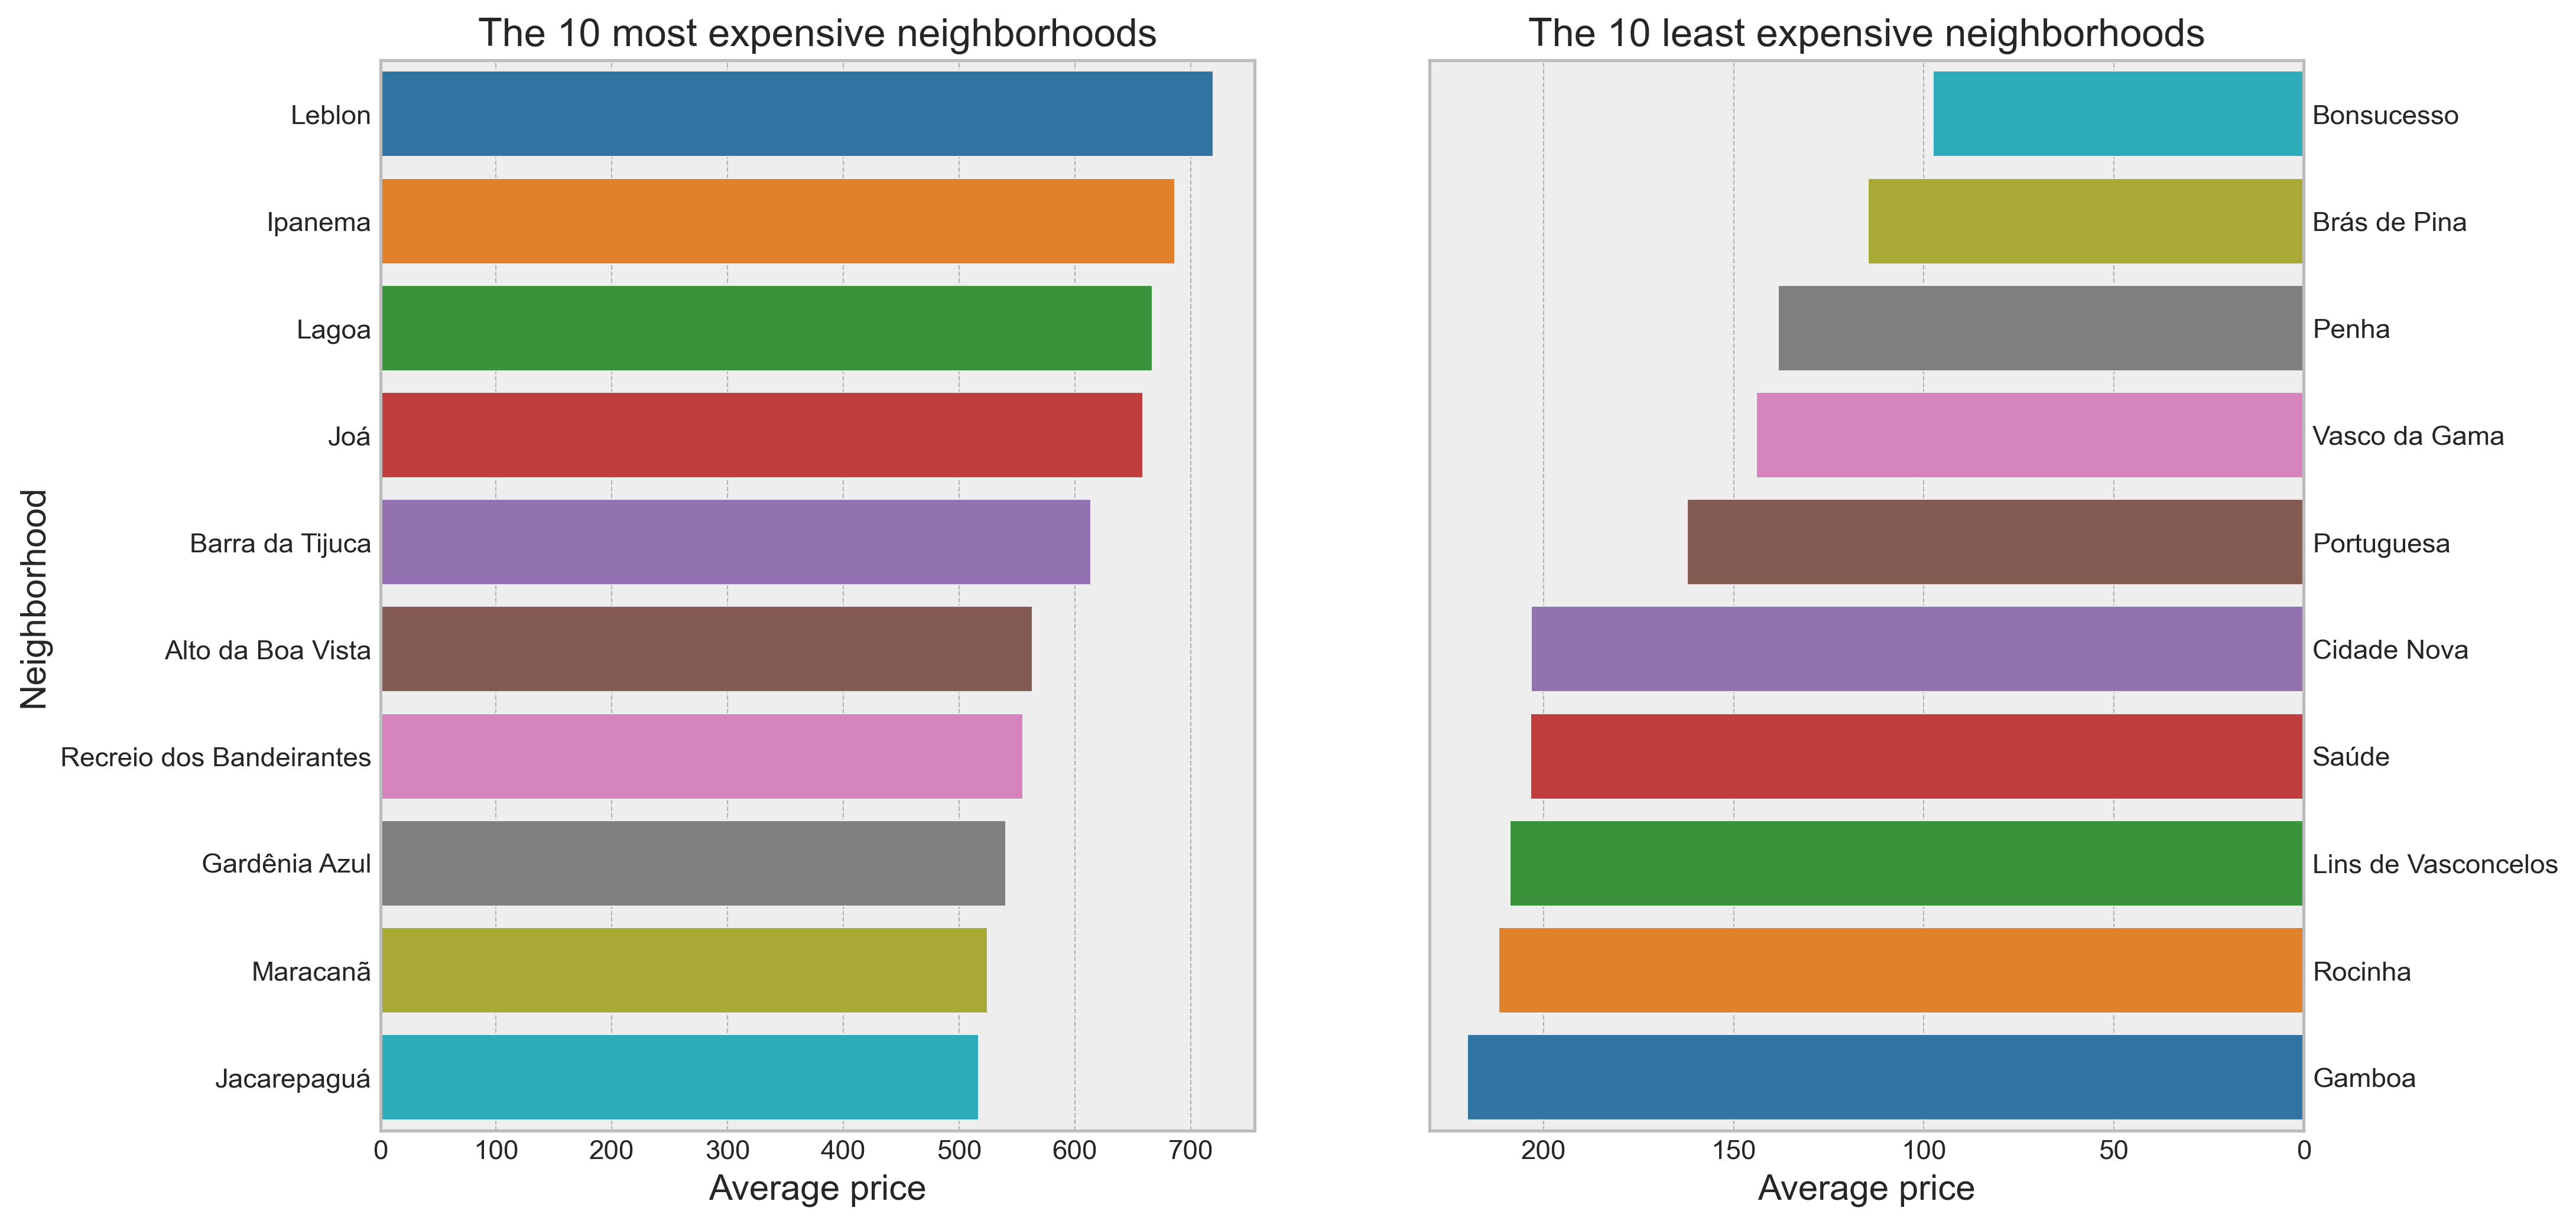

In [107]:
# Plotting the 10 most and 10 least expensive neighborhoods (for neighborhoods with at least 10 listings)
fig, axes = plt.subplots(1, 2, figsize=(14,8), dpi=300)

sns.barplot(data=neighb_data[neighb_data['Total of listings'] > 10]\
            .sort_values(by='Average price',ascending=False).iloc[:10], palette='tab10',
            x='Average price', y='Neighborhood', ax=axes[0])

axes[0].set_title('The 10 most expensive neighborhoods', fontsize=16)

sns.barplot(data=neighb_data[neighb_data['Total of listings'] > 10]\
            .sort_values(by='Average price',ascending=True).iloc[:10], palette='tab10_r',
            x='Average price', y='Neighborhood', ax=axes[1])

axes[1].set_title('The 10 least expensive neighborhoods', fontsize=16)
axes[1].set_xlim(230, 0)
axes[1].set_ylabel('')
axes[1].yaxis.tick_right()

As expected, the most touristic neighborhoods are always more expensive, while districts with slums and high levels of violence have much lower prices.

In [108]:
# Filtering the main dataframe with only listings for the 10 most common neighborhoods
mostcommon_neighbs = rj_listings[rj_listings['neighbourhood_cleansed'].isin(
                    rj_listings['neighbourhood_cleansed'].value_counts().iloc[:10].index)]

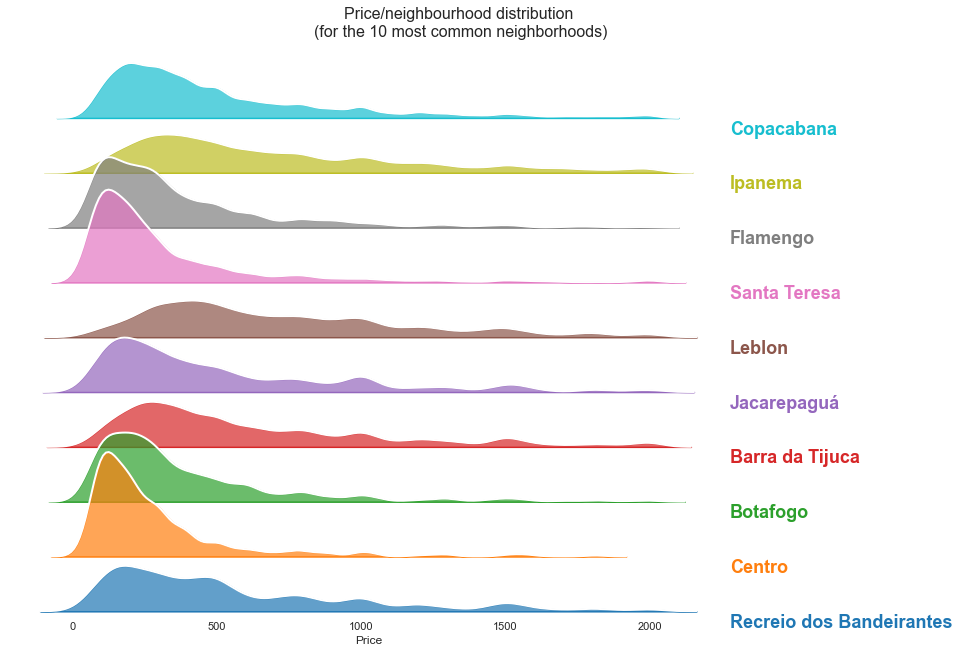

In [109]:
# Plotting a ridge plot with the price distribution for the 10 most common neighborhoods
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
g = sns.FacetGrid(mostcommon_neighbs, row="neighbourhood_cleansed", hue="neighbourhood_cleansed",
                  palette='tab10_r', aspect=8, height=1.75) 

g.map(sns.kdeplot, 'price', bw_adjust=.5, clip_on=False, fill=True, alpha=0.7, linewidth=1.5)
g.map(sns.kdeplot, 'price', clip_on=False, color="w", lw=2, bw_adjust=.5)

def label(x, color, label):
    ax = plt.gca()
    ax.text(1, -.1, label, fontweight="bold", color=color, ha="left", va="center", fontsize=18, transform=ax.transAxes)

g.map(label, "price")

g.fig.subplots_adjust(hspace=-.5)

g.set_titles("")
g.set(yticks=[])
g.set(xlabel='Price')
g.despine(bottom=True, left=True)
plt.subplots_adjust(bottom=.5)
g.fig.suptitle('Price/neighbourhood distribution \n(for the 10 most common neighborhoods)', fontsize=16)
plt.show()

These density plots can speak for themselves.

**Touristics areas (Copacabana, Ipanema, Leblon, Barra da Tijuca) have a very high variation of prices**, ranging from **less than \\$50 to more than \\$1000**, whereas **Flamengo, Santa Teresa and Centro**, for instance, have a **higher concentration of prices in the \\$200**, with lower densities after that.

If you don't want to spend much money, it's best to avoid the beach.

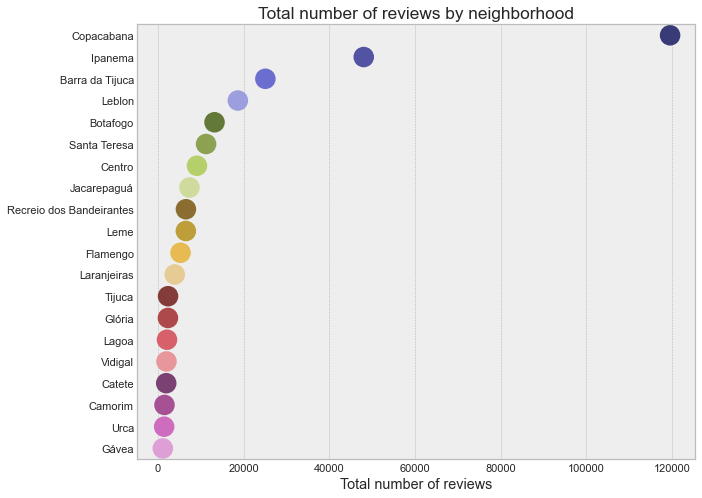

In [112]:
# Plotting total number of reviews by neighborhood
plt.style.use('bmh')

plt.figure(figsize=(10,8))

sns.pointplot(data=neighb_data.sort_values(by='Total number of reviews', ascending=False).iloc[:20], 
              y='Neighborhood', x='Total number of reviews', palette='tab20b', scale = 1.75)
plt.title('Total number of reviews by neighborhood')
plt.ylabel('')
plt.show()

People are definetely looking more frequently for **places near touristics areas**, such as the **beaches** and where the **Cristo Redentor statue** is located (Santa Teresa).

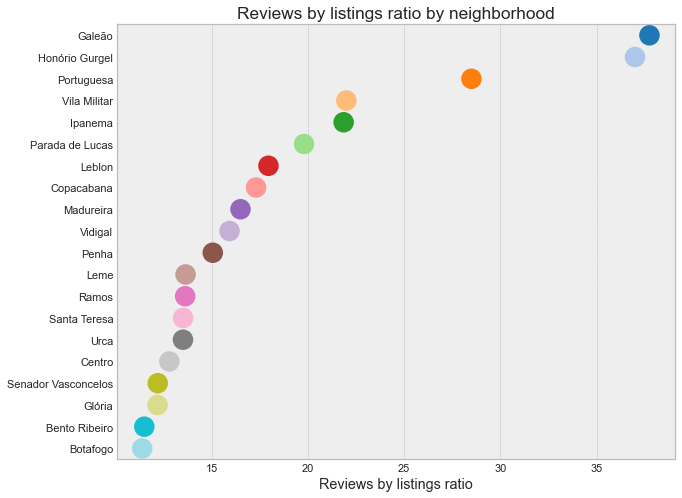

In [113]:
# Plotting reviews by listings ratio by neighborhood
plt.figure(figsize=(10,8))

sns.pointplot(data=neighb_data.sort_values(by='Reviews by listings ratio', ascending=False).iloc[:20], 
              y='Neighborhood', x='Reviews by listings ratio', palette='tab20', scale = 1.75)
plt.title('Reviews by listings ratio by neighborhood')
plt.ylabel('')
plt.show()

The plot above shows the **ratio between how many reviews the accommodations in a determined neighborhood have by how many listings there are in this neighborhood**.

This helps showing how successful (or how profitable) a place can be in a determined neighborhood.

In **Galeão**, for instance, area where the Rio de Janeiro/Galeão International Airport is located, there are only **4 listings** available, but they've been **reviewed 151 times**, which means that it can be a good idea to have an accommodation for rent in this area.

If someone is looking for profit in a **touristic area, Ipanema, Leblon and Copacabana can be very good options**.

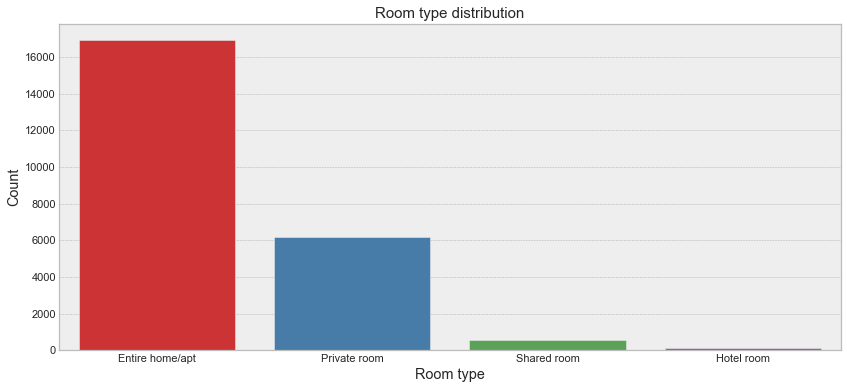

In [114]:
# Plotting room type distribution for the entire dataset
plt.figure(figsize=(14,6))

sns.countplot(data=rj_listings, x='room_type', palette='Set1')

plt.xlabel('Room type')
plt.ylabel('Count')
plt.title('Room type distribution', fontsize=15)
plt.show()

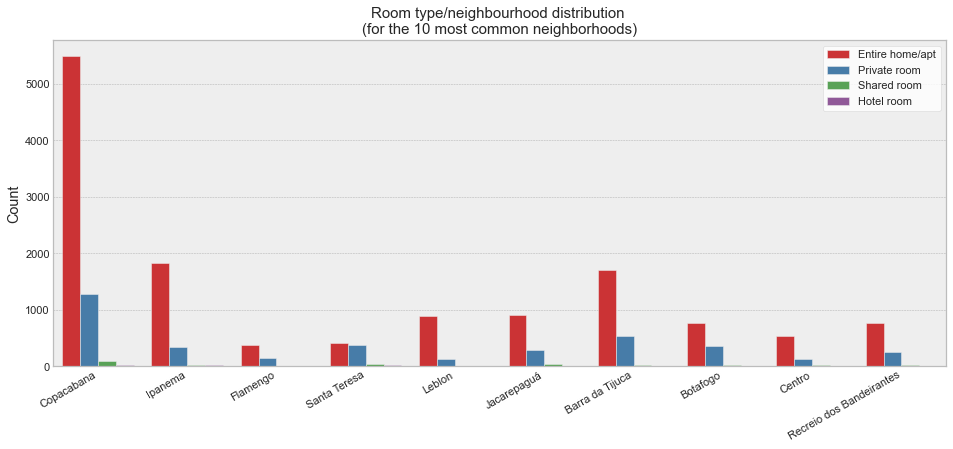

In [115]:
# Plotting room type distribution by neighborhood for the 10 most common neighborhoods
plt.figure(figsize=(16,6))

sns.countplot(data=mostcommon_neighbs, x='neighbourhood_cleansed', hue='room_type', palette='Set1')

plt.xlabel('')
plt.ylabel('Count')
plt.xticks(rotation=30, ha='right')
plt.title('Room type/neighbourhood distribution \n(for the 10 most common neighborhoods)', fontsize=15)
plt.legend(loc='upper right', facecolor='white')
plt.show()

**Entire home/apartments** are always the most rented places in AirBnB (this probably applies to most cities in the world). It's not any different in Rio de Janeiro. More than 71% of the accommodations are entire places.

**Hotel rooms** are not AirBnB's most predominant product, since hotels usually have different platforms to book their rooms, such as **Trivago** and **Expedia**. In this dataset, less than 0.5% of the listings are hotel rooms.

Looking at the room type by neighborhood distribution, we can see that **most districts have way more entire home/apartments for rent than private rooms**, except for Santa Teresa, which have almost as many private rooms as entire places.

In [116]:
print(f'{round(rj_listings["host_identity_verified"].value_counts(normalize=True)[1]*100, 2)}% of the hosts are verified.')
print(f'{round(rj_listings["host_identity_verified"].value_counts(normalize=True)[0]*100, 2)}% of the hosts are not verified.')

61.23% of the hosts are verified.
38.77% of the hosts are not verified.


In [117]:
# Creating a table showing how many reviews are there for verified and not verified hosts
host_verif_reviews = pd.DataFrame(rj_listings.groupby(['host_identity_verified'])['number_of_reviews'].sum()).rename(
                    index={0: 'Not verified', 1: 'Verified'},    
                    columns={'number_of_reviews': 'Number of reviews'}).rename_axis(index='Host identity situation')

host_verif_reviews

Number of reviews
Host identity situation                   
Not verified                         53547
Verified                            247726

In [118]:
# Creating a table showing how many reviews are there for superhosts and not superhosts
superhost_reviews = pd.DataFrame(rj_listings.groupby(['host_is_superhost'])['number_of_reviews'].sum()).rename(
                    index={0: 'No', 1: 'Yes'},    
                    columns={'number_of_reviews': 'Number of reviews'}).rename_axis(index='Is host a superhost?')

superhost_reviews

Number of reviews
Is host a superhost?                   
No                               144369
Yes                              156904

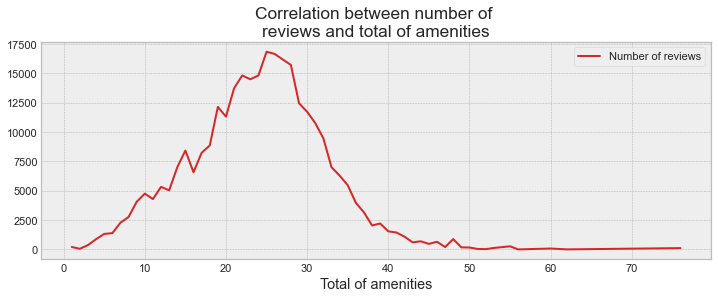

In [119]:
# Plotting the correlation between number of reviews and total of amenities by listing
amenities_reviews = pd.DataFrame(rj_listings.groupby(['total_amenities'])['number_of_reviews'].sum()).rename(    
                    columns={'number_of_reviews': 'Number of reviews'}).rename_axis(index='Total of amenities')

amenities_reviews.plot(kind='line', figsize=(12,4), color='tab:red')
plt.title('Correlation between number of \nreviews and total of amenities')
plt.show()

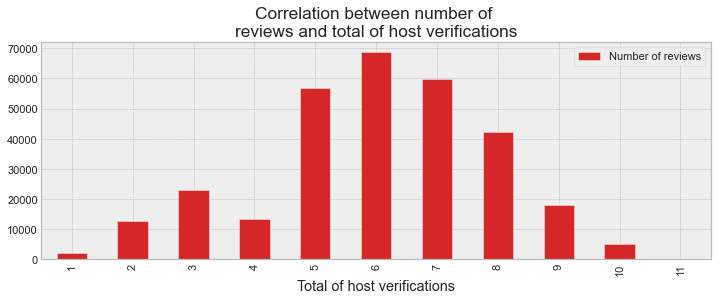

In [122]:
# Plotting the correlation between number of reviews and total of host verifications by listing
hostverif_reviews = pd.DataFrame(rj_listings.groupby(['total_host_verifications'])['number_of_reviews'].sum()).rename(    
                    columns={'number_of_reviews': 'Number of reviews'}).rename_axis(index='Total of host verifications')

hostverif_reviews.plot(kind='bar',figsize=(12,4), color='tab:red')
plt.title('Correlation between number of \nreviews and total of host verifications')
plt.show()

With the previous tables and plots, we can come up with some ideas (even though these are not fully conclusive):
- Most hosts **(more than 60%) are verified** by AirBnB.
- More than **82% of the reviews** are from accommodations owned by **verified hosts**.
- Being a **superhost doesn't necessarily mean the place will be rented more often**, but it helps a little.
- Having (or at least listing) around **25 amenities can have a great impact** in how many people will rent the accommodation.
- The same goes for host verifications: having **between 5 and 8 verifications is ideal** for a host.

***

## Conclusions

Even though we deeply analyzed a wealth of data about Airbnb reservations in the city of Rio de Janeiro, there are still a whole lot of factors that can influence our numbers and results, such as seasonality, reviews scores, availability and so forth.

Despite that, we now have a good idea of how these listings are distributed across the city and how their features affect their success.

- If you're looking to rent your place, the money is on the beach (but don't neglect the urban areas, as some can be very profitable as well!). 
- Since what most people are looking for are entire places, this can be the safest thing to do, but there are a lot of people who are looking for smaller and cheaper places, private or even shared rooms. If you have a spare room, renting it on Airbnb can be a good way to make some money.
- Don't forget to verify your host account, since the majority of reviewed places were owned by verified hosts, and include at least five of your own verifications. Also, invest time in describing very well all of your accommodation's amenities, and if it doesn't have the basic services and utilities, invest some money before making the place available.
- If you're looking for a place to stay, it all depends on how much money you're willing to spend and how concerned you're about your own safety, since cheaper neighborhoods tend to be more violent. Check to see if your host has all necessary verifications and if its profile is verified.

A lot of good relationships and correlations have been found in this analysis. There's much more that can be done here, such as analyzing which amenities or verifications are the most important, what neighborhoods have the tendency to grow in the future, how can descriptions influence the success of a listing... the list goes on and on!

For now, I hope this notebook was enjoyable and useful! Thanks for reading!